In [20]:
import sys
from pathlib import Path
import torch
import numpy as np
import py3Dmol
import os
from rdkit import Chem
import pandas as pd
import ast

basedir = Path("/home/domainHomes/ssakharov/master_thesis/crossdocked/processed_crossdock_noH_ca_only_temp")

models = []
models.append(basedir / "predictions_r10_t50")
models.append(basedir / "predictions_r1_t500_n100_second")
models.append(basedir / "predictions_r1_t500_ddim_400_nu_0_n100_quad")
models.append(basedir / "predictions_r1_t500_ddim_250_nu_0_n100_quad")
models.append(basedir / "predictions_r1_t500_ddim_100_nu_0_n100_quad")
models.append(basedir / "predictions_r1_t500_ddim_50_nu_0_n100_quad")


In [21]:
def get_random_molecule_file(path):
    path = path / "processed"
    return np.random.choice(os.listdir(path))

def get_molecules(basedir, models, mol_name):
    mols_per_model = []
    qvina_per_model = []
    qed_per_model = []
    sa_per_model = []
    for model in models:
        mol_path = basedir / model / "processed" /mol_name
        with open(mol_path, "r") as f:
            mols_str = f.read().split("$$$$\n")[0:-1]
        qvian = read_qvina_scores(basedir / model, mol_name)
        qed, sa = get_other_metrics(basedir / model, mol_name)
        assert len(mols_str) == len(qvian) == len(qed) == len(sa)
        mols_per_model.append(mols_str)
        qvina_per_model.append(qvian)
        qed_per_model.append(qed)
        sa_per_model.append(sa)
    return mols_per_model, qvina_per_model, qed_per_model, sa_per_model

def read_qvina_scores(path, mol_name):
    qvina_file = path / "qvina" / "qvina2_scores.csv"
    if not qvina_file.exists():
        return None
    df = pd.read_csv(qvina_file, index_col=0)
    # df["scores"] = df["scores"].apply(lambda x: np.array(ast.literal_eval(x.replace("nan, ", "").replace(", nan]", "]"))))
    df["ligand_name"] = df["ligand"].apply(lambda x: x.split("/")[-1])
    df_filtered = df[df["ligand_name"] == mol_name].copy()
    df_filtered["scores"] = df_filtered["scores"].apply(lambda x: np.array(ast.literal_eval(x.replace("nan", "0"))))
    return df_filtered["scores"].values[0]

def get_true_molecule(basedir, mol_name):
    mol_path = basedir / "test" / mol_name.replace("_gen", "")
    with open(mol_path, "r") as f:
        mols_str = f.read()
    return mols_str

def get_other_metrics(path, mol_name):
    df_metric = pd.read_csv(path / "metrics.csv", header=0)
    df_metric_mol = df_metric[df_metric["file_names"] == mol_name]
    qed = ast.literal_eval(df_metric_mol["QED"].values[0][1:-1].replace("None", "0"))
    sa = ast.literal_eval(df_metric_mol["SA"].values[0][1:-1].replace("None", "0"))
    return np.array(qed), np.array(sa)

In [22]:
random_file = get_random_molecule_file(models[0])
print(random_file)
mols, qvinas, qeds, sas = get_molecules(basedir, models, random_file)
true_mol = get_true_molecule(basedir, random_file)
# qed, sa = get_other_metrics(basedir / models[0], random_file)
mols, qvinas, qeds, sas = np.array(mols), np.array(qvinas), np.array(qeds), np.array(sas)
[len(m) for m in mols], qvinas.shape, qeds.shape, sas.shape

4pxz-A-rec-4pxz-6ad-lig-tt-min-0-pocket10_4pxz-A-rec-4pxz-6ad-lig-tt-min-0_gen.sdf


([100, 100, 100, 100, 100, 100], (6, 100), (6, 100), (6, 100))

In [23]:
sa_qed = "qed"

sorted_idx = np.zeros_like(qvinas)
for i in range(qvinas.shape[0]):
    qvina_temp = abs(qvinas[i])
    qed_temp = qeds[i]
    sa_temp = sas[i]
    if sa_qed == "sa":
        norm_sum = qvina_temp / np.max(qvina_temp) + sa_temp / np.max(sa_temp)
    else:
        norm_sum = qvina_temp / np.max(qvina_temp) + qed_temp / np.max(qed_temp)
    sorted_idx[i] = np.argsort(norm_sum)

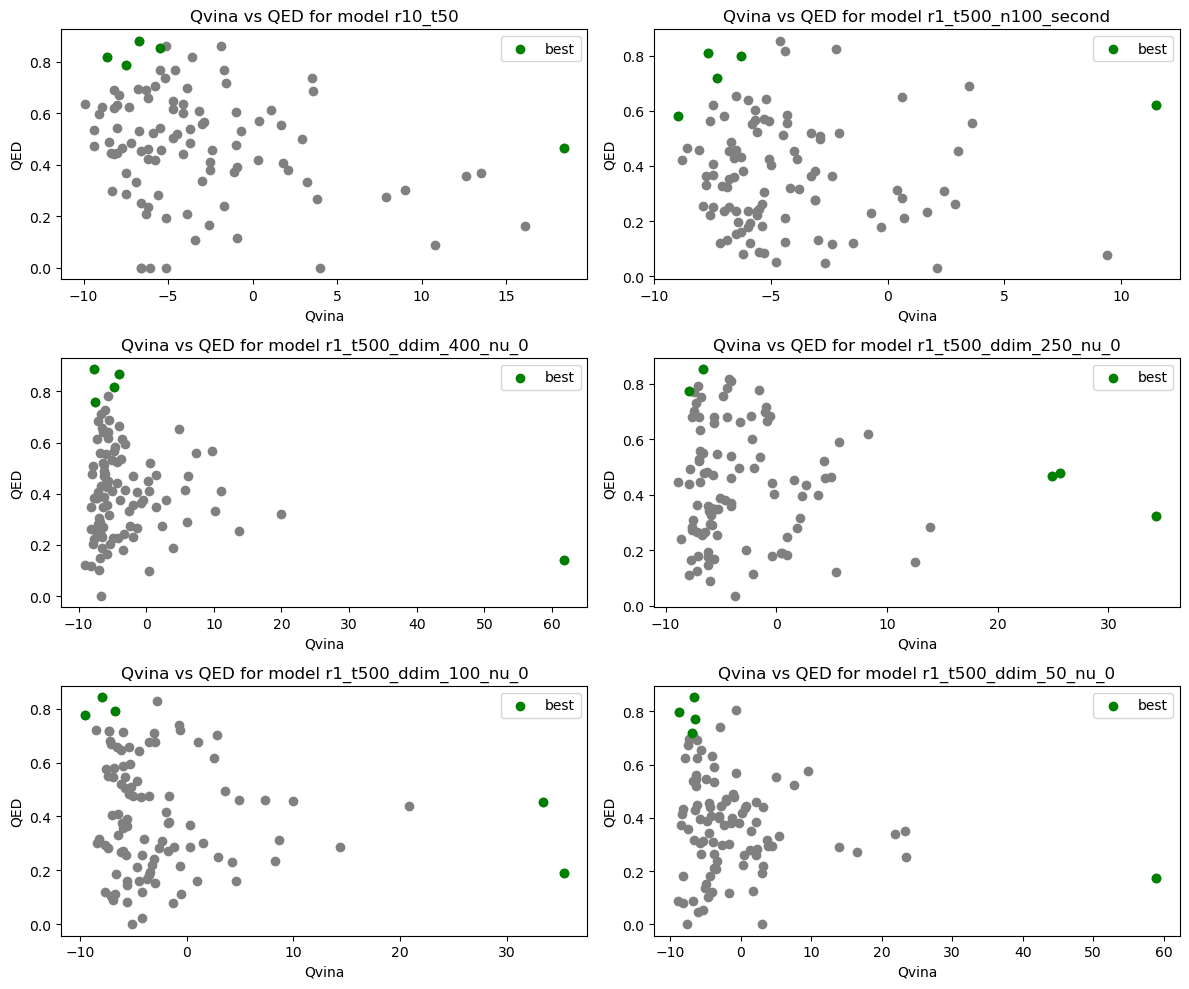

In [24]:
# plot qed vs qvina for each model
import matplotlib.pyplot as plt
cols = 2
rows = np.ceil(len(models) / cols).astype(int)
fig, ax = plt.subplots(rows, cols, figsize=(12, 10))
top5_mols = []
top5_qvina = []
top5_qed = []
top5_sa = []
for i in range(len(models)):
    best_idx = sorted_idx[i][-5:].astype(int)
    if sa_qed == "qed":
        ax[i//2, i%2].scatter(qvinas[i], qeds[i], c="gray")
        ax[i//2, i%2].set_ylabel("QED")
        ax[i//2, i%2].scatter(qvinas[i][best_idx], qeds[i][best_idx], c="g", label="best")
        ax[i//2, i%2].set_title(f"Qvina vs QED for model {models[i].name.split('predictions_')[-1].replace('_n100_quad', '')}")
    elif sa_qed == "sa":
        ax[i//2, i%2].scatter(qvinas[i], sas[i], c="gray")
        ax[i//2, i%2].set_ylabel("SA")
        ax[i//2, i%2].scatter(qvinas[i][best_idx], sas[i][best_idx], c="g", label="best")
        ax[i//2, i%2].set_title(f"Qvina vs SA for model {models[i].name.split('predictions_')[-1].replace('_n100_quad', '')}")
    ax[i//2, i%2].set_xlabel("Qvina")
    # ax[i//2, i%2].set_xlim(-12, 0)
    ### color 10 best 
    ax[i//2, i%2].legend()
    top5_mols.append(mols[i][best_idx])
    top5_qvina.append(qvinas[i][best_idx])
    top5_qed.append(qeds[i][best_idx])
    top5_sa.append(sas[i][best_idx])
plt.tight_layout()



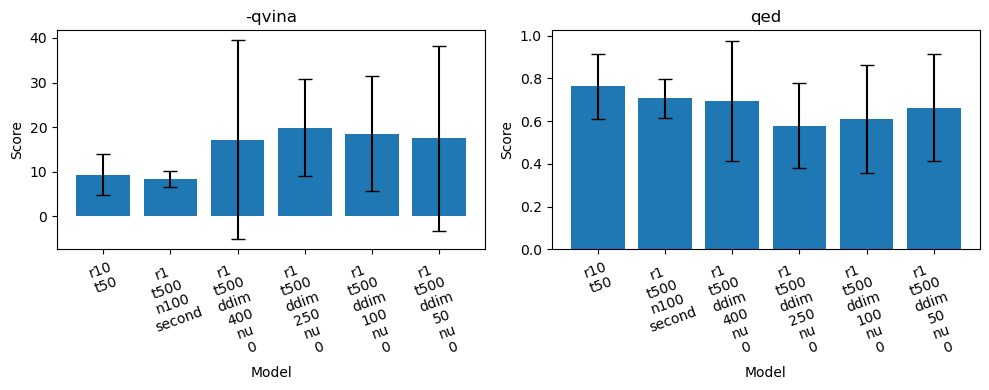

In [25]:
### plot 2 bar plot with errorbars for top 5 molecules for qvina and qed separately (x-axis is model name, y-axis is score)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
if sa_qed == "qed":
    dict_scores = {"-qvina": top5_qvina, "qed": top5_qed}
elif sa_qed == "sa":
    dict_scores = {"-qvina": top5_qvina, "sa": top5_sa}
model_names = [m.name.split("predictions_")[1].replace("_n100_quad", "") for m in models]
model_names = [m.replace("_", "\n") for m in model_names]
for i, (name, scores) in enumerate(dict_scores.items()):
    scores = abs(np.array(scores))
    scores_mean = scores.mean(axis=1)
    scores_std = scores.std(axis=1)
    ax[i].bar(model_names, scores_mean, yerr=scores_std, capsize=5)
    ax[i].set_title(name)
    ax[i].set_ylabel("Score")
    ax[i].set_xlabel("Model")
    ## turn x labels
    ax[i].tick_params(axis='x', rotation=20)

plt.tight_layout()



In [26]:
# view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
cols = 5
rows = len(mols)
view = py3Dmol.view(width=1200, height=800, linked=False, viewergrid=(rows, cols), js='https://3dmol.org/build/3Dmol.js')
for row in range(rows):
    mols_model = top5_mols[row]
    for i in range(cols):
        view.addModelsAsFrames(mols_model[i], viewer=(row, i))
        view.addStyle({'model': -1}, {'stick': {}}, viewer=(row, i))


view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [27]:
view = py3Dmol.view(width=400, height=400, js='https://3dmol.org/build/3Dmol.js')
view.addModelsAsFrames(true_mol)
# view.addStyle({'model': -1}, {'sphere': {}})
view.addStyle({'model': -1}, {'stick': {}})
view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol